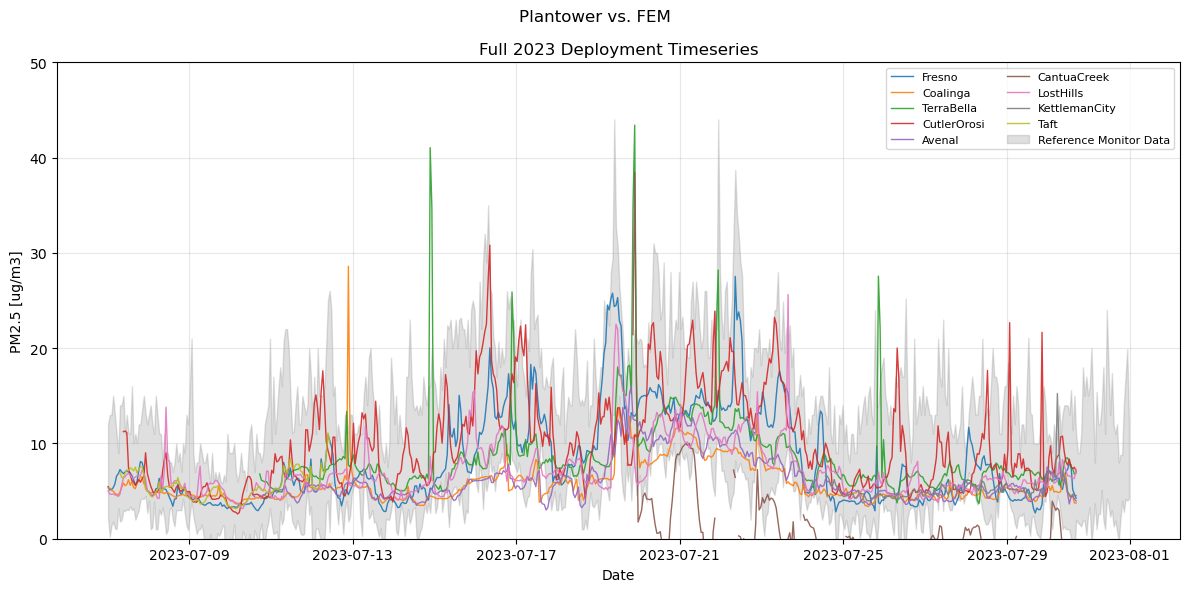

In [5]:
#Run this code to create timeseries of vozbox plantowers and reference sites
import sys
import pandas as pd
import matplotlib.pyplot as plt
import os

sys.path.append(os.path.abspath(".."))
from data_tools import handle_datetime
import data_tools.deployment_sets as sets
from data_tools import my_setup

def create_ptwdatetime_column(ptw_file):
    ptwdf = pd.read_csv(ptw_file, usecols = ['date_time','PM_calibrated_ClarityRemake'])
    ptwdf = handle_datetime.create_standard_datetime(ptwdf)
    return ptwdf

def rename_pm_column(ptw_file, ptwdf):
    site = os.path.basename(ptw_file).split('_', 1)[0]
    ptwdf = ptwdf.rename(columns={'PM_calibrated_ClarityRemake': f'{site}_ptw'})
    return ptwdf

def process_datetime(ref_site_df):
    ref_site_df = handle_datetime.create_utc_for_CARB(ref_site_df)
    ref_site_df = handle_datetime.utc_to_CA(ref_site_df)
    ref_site_df = (ref_site_df.drop(columns=['date', 'start_hour']))
    return ref_site_df

# Define file names and locations for reference and voz plantowers
ptwprefix = "../reference_files/2023PlantowerDataCalibrated/"
ptw_site_names = sets.calibrated_files_2023()

ref_file = "../reference_files/PM25HR_PICKDATA_2023-12-31-AllReferences.csv"
ref_all = pd.read_csv(ref_file, usecols=['site', 'date', 'start_hour', 'value'])
ref_IDs = sets.CARB_pm25_IDs()

ptw_file_names = []
for site in ptw_site_names:
    ptw_file_names.append(rf"{ptwprefix}{site}")

timeseries = None
for site_name, site_id in ref_IDs.items():
    site_data = ref_all.loc[ref_all['site'] == site_id, ['date', 'start_hour', 'value']].copy()
    if site_data.empty:
        continue
    site_data = process_datetime(site_data)
    site_data = site_data.rename(columns={'value': f'{site_name}_FEM'})

    if timeseries is None:
        timeseries = site_data
    else:
        timeseries = timeseries.join(site_data, how='outer')

timeseries['max_reference_pm'] = timeseries.max(axis=1)
timeseries['min_reference_pm'] = timeseries.min(axis=1)

for file in ptw_file_names:
    ptwdf = rename_pm_column(file, create_ptwdatetime_column(file))
    if timeseries is None:
        timeseries = ptwdf
    else:
        timeseries = timeseries.join(ptwdf, how='left')

start_date = pd.to_datetime("2023-07-07")
end_date = pd.to_datetime("2023-08-01")

timeseries_filtered = timeseries[(timeseries.index >= start_date) & (timeseries.index <= end_date)]

df = timeseries_filtered.dropna(how='all', axis=1)

plt.figure(figsize=(12,6))
for col in df.columns:
    name=os.path.basename(col).split('_', 1)[0]
    if('FEM' in col or 'reference' in col):
        continue
    else:
        alpha = 0.9
        lw = 1
        z = 2
    plt.plot(df.index, df[col], label=name, linewidth=lw, alpha = alpha, zorder = z)
plt.fill_between(
    timeseries_filtered.index,                          # x = datetime index
    timeseries_filtered['min_reference_pm'],               # lower y bound (series)
    timeseries_filtered['max_reference_pm'],               # upper y bound (series)             # mask of same length
    alpha=0.25,
    color='gray',
    label='Reference Monitor Data'
)
plt.legend(ncol=2, fontsize=8)
plt.title("Full 2023 Deployment Timeseries")
plt.suptitle("Plantower vs. FEM")
plt.xlabel("Date")
plt.ylabel("PM2.5 [ug/m3]")
plt.ylim(0, 50)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig(rf"./images/PlantowerFullTimeseries.jpg", format='jpg', dpi=300)
plt.show()


In [ ]:
# Define file names and locations for reference and voz plantowers
senprefix = "../reference_files/2023SensirionDataCalibrated/"
sensuffix = "_mod_calibrated.csv"
sen_site_names = sets.files_2023()